In [1]:
import numpy as np
import pandas as pd
import json
from matplotlib import pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from sklearn.metrics import mean_absolute_error

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt

import itertools
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('data/final_data.csv', parse_dates=['StartTime'], index_col='StartTime')
df.head()

,green_energy_SP,SP_Load,green_energy_UK,UK_Load,green_energy_DE,DE_Load,green_energy_DK,DK_Load,green_energy_SE,SE_Load,green_energy_HU,HU_Load,green_energy_IT,IT_Load,green_energy_PO,PO_Load,green_energy_NE,NE_Load,label
StartTime,,,,,,,,,,,,,,,,,,,
2021-12-31 23:00:00,11244.0,20827.0,0.0,1244.0,157373.0,165125.0,3652.0,3314.0,11060.0,15331.0,1376.0,16457.0,5801.0,21121.0,4641.0,14438.0,12768.0,40706.0,3
2022-01-01 00:00:00,10827.0,19530.0,0.0,1244.0,157373.0,165125.0,3605.0,3218.0,11107.0,15331.0,1376.0,16457.0,5745.0,19756.0,4491.0,13935.0,12768.0,40706.0,3
2022-01-01 01:00:00,11140.0,18383.0,0.0,1131.0,151747.0,160415.0,3309.0,3126.0,11036.0,15270.0,1526.0,15426.0,6228.0,18685.0,4436.0,13579.0,11131.0,39465.0,3
2022-01-01 02:00:00,11361.0,17680.0,0.0,1091.0,147938.0,158035.0,3043.0,3080.0,10509.0,15150.0,1560.0,14781.0,6407.0,18124.0,4568.0,13397.0,11324.0,38923.0,3
2022-01-01 03:00:00,11247.0,17396.0,0.0,969.0,141816.0,157016.0,2852.0,3044.0,10770.0,15387.0,1287.0,14630.0,5760.0,18400.0,4559.0,13364.0,11290.0,38211.0,3


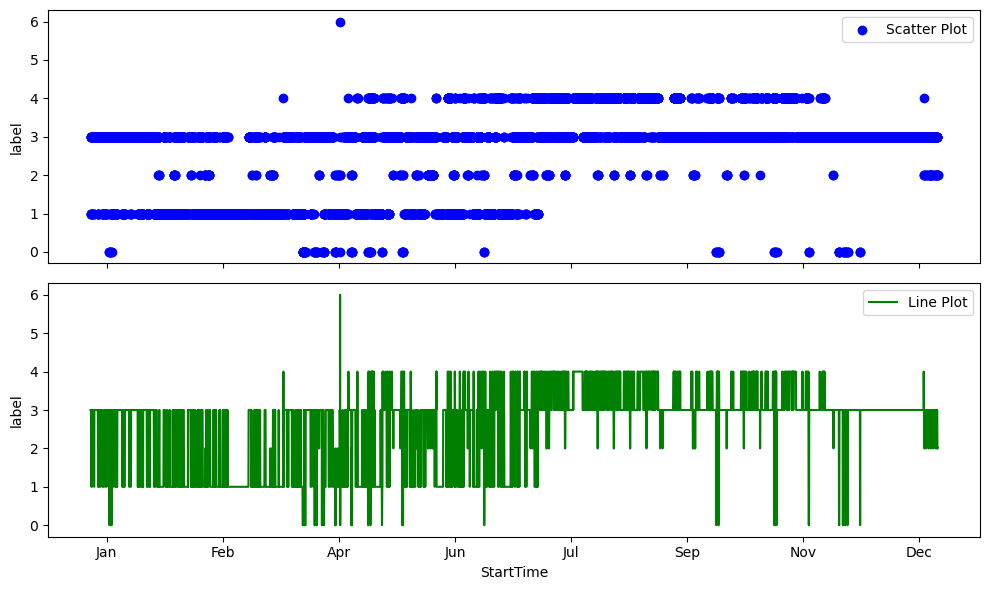

In [3]:

df = df.sort_index()
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 6))

# Scatter plot
ax1.scatter(x=df.index, y=df['label'], color='blue', label='Scatter Plot')
ax1.set_ylabel('label')
ax1.legend()

# Line plot
ax2.plot(df.index, df['label'], color='green', label='Line Plot')
ax2.set_xlabel('StartTime')
ax2.set_ylabel('label')
ax2.xaxis.set_major_locator(mdates.MonthLocator())
ax2.xaxis.set_major_formatter(DateFormatter('%b'))
ax2.xaxis.set_major_locator(MaxNLocator(nbins=10)) 

ax2.legend()

plt.tight_layout()
plt.show()

The Augmented Dickey-Fuller (ADF) test is a statistical test for stationarity. The test provides an ADF statistic and a p-value. The interpretation of these values is crucial in determining whether your time series data is stationary.

In [4]:
result = adfuller(df['label'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -6.9883516865907955
p-value: 7.861623388931239e-10
Critical Values:
	1%: -3.431099968539641
	5%: -2.86187143613454
	10%: -2.5669464184887825


In our case ADF Statistic < Critical Value and P-Value < 0.05.

This is a s
Strong evidence to reject the null hypothes, thus t The data is likely stationary.

In [5]:
train_ratio = 0.6  
val_ratio = 0.2    
test_ratio = 0.2

train_split = int(train_ratio * len(df))
val_split = int((train_ratio + val_ratio) * len(df))

train_set = df['label'].iloc[:train_split]
val_set = df['label'].iloc[train_split:val_split]
test_set = df['label'].iloc[val_split:]

test_set.to_csv('./data/test_set.csv', index=False)

print(f"Length of training set: {len(train_set)}")
print(f"Length of test set: {len(test_set)}")
print(f"Length of validation set: {len(val_set)}")

Length of training set: 5256
Length of test set: 1752
Length of validation set: 1752


In [6]:
print('Total length of data frame', len(df))
print('Training set', len(train_set))
print('Training set', len(test_set))
print('Sum of train and test sets', len(train_set)+len(test_set))

Total length of data frame 8760
Training set 5256
Training set 1752
Sum of train and test sets 7008


Performing a grid search to find the best parameters for tuning an ARIMA model involves systematically testing different combinations of hyperparameters and selecting the set that results in the best model performance. 

In [7]:
p_values = range(0, 3)  
d_values = range(0, 2)  
q_values = range(0, 3)  

# Creating a list of all possible combinations of p, d, and q
parameter_grid = list(itertools.product(p_values, d_values, q_values))

best_model_params = None
best_mae = float('inf')

for params in parameter_grid:
    p, d, q = params
    model = ARIMA(train_set, order=(p, d, q))
    results = model.fit()
    
    # Making predictions on the validation set
    forecast = results.get_forecast(steps=len(val_set))
    predicted_values = forecast.predicted_mean
    
    # Evaluating the model using Mean Absolute Error
    mae = mean_absolute_error(test_set, predicted_values)
    
    # Update the best model if the current one is better
    if mae < best_mae:
        best_mae = mae
        best_model_params = (p, d, q)

best_model = ARIMA(train_set, order=best_model_params)
best_results = best_model.fit()

In [8]:
best_results.save('./models/model.pkl')

In [9]:
print(results.summary())
print('Best Mean Absolute Error:', best_mae)
print('Best model parameters are:', best_model_params)

                               SARIMAX Results                                
Dep. Variable:                  label   No. Observations:                 5256
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -4739.124
Date:                Tue, 21 Nov 2023   AIC                           9488.248
Time:                        03:25:25   BIC                           9521.082
Sample:                             0   HQIC                          9499.727
                               - 5256                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5148      0.291      1.771      0.077      -0.055       1.085
ar.L2          0.2337      0.228      1.027      0.304      -0.212       0.680
ma.L1         -0.7439      0.292     -2.545      0.0

In [10]:
# Generating predictions and aligning the predicted values with the index of a test set
forecast_steps = len(test_set)
forecast = results.get_forecast(steps=forecast_steps)
predicted_values = forecast.predicted_mean
predicted_values.index = test_set.index
predicted_values = predicted_values.round()


comparison_df = pd.DataFrame({'Actual': test_set, 'Predicted': predicted_values})

print(comparison_df)

                     Actual  Predicted
StartTime                             
2022-10-20 00:00:00       3        4.0
2022-10-20 01:00:00       3        4.0
2022-10-20 02:00:00       3        4.0
2022-10-20 03:00:00       3        4.0
2022-10-20 04:00:00       3        4.0
...                     ...        ...
2022-12-31 19:00:00       3        3.0
2022-12-31 20:00:00       2        3.0
2022-12-31 21:00:00       2        3.0
2022-12-31 22:00:00       2        3.0
2022-12-31 23:00:00       2        3.0

[1752 rows x 2 columns]


In [11]:
mae = mean_absolute_error(test_set, predicted_values)
print(f'Mean Absolute Error: {mae}')

mse = mean_squared_error(test_set, predicted_values)
print(f"Mean Squared Error (MSE): {mse}")

rmse = sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error: 0.1678082191780822
Mean Squared Error (MSE): 0.2602739726027397
Root Mean Squared Error (RMSE): 0.5101705328640019


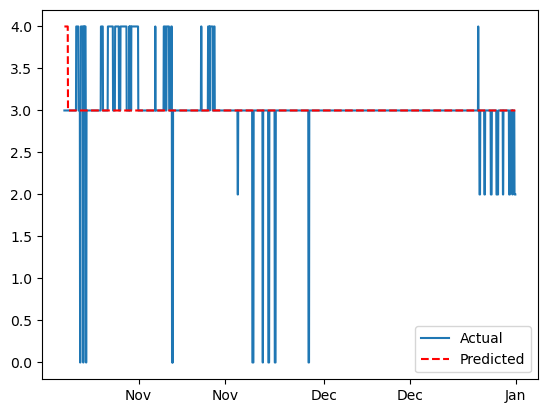

In [12]:
# Plotting the actual vs. predicted values

plt.plot(test_set, label='Actual')
plt.plot(predicted_values, label='Predicted', linestyle='dashed', color='red')
plt.legend()

plt.gca().xaxis.set_major_formatter(DateFormatter('%b'))
plt.show()

In [13]:
predicted_values = predicted_values.reset_index(drop=True)
predicted_values.to_json('predictions/predictions.json', orient='index')